# Franke Function Regression problem with PyTorch

In [1]:
import torch as torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torcheval.metrics import R2Score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})

from utils import FrankeFunction

plt.style.use('seaborn-darkgrid')

C:\Users\Erik\AppData\Local\Temp\ipykernel_17176\1243502911.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
N  = 100

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
yy, xx = np.meshgrid(x, y)

zz = FrankeFunction(xx, yy, 0.01)
target = zz.reshape(-1,1)

In [4]:
#Concatenate date & tensor-transform
data = np.concatenate((xx.flatten().reshape(-1,1), yy.flatten().reshape(-1,1)), axis=1)
data = torch.tensor(data, dtype=torch.float32)
Z = torch.tensor(target, dtype=torch.float32)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size=2):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 50),
            nn.Sigmoid(),
            nn.Linear(50, 25),
            nn.Sigmoid(),
            nn.Linear(25, 1))

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

In [5]:
model = Network(2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.MSELoss()
num_epochs = 2000
batch_size = 32
loss_evolution = []
r2_evolution = []
metric = R2Score()

#Random shuffling
perm = torch.randperm(data.size()[0])
data = data[perm]
Z = Z[perm]

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        batch_target = Z[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)
        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    model.eval()
    output = model(data)
    loss_value = loss(output, Z)
    metric.update(output, Z)
    metric_value = metric.compute()

    loss_evolution.append(loss_value.item())
    r2_evolution.append(metric_value)
    if epoch % 150 == 0:
        print(f'Epoch {epoch} | Loss: {loss_value.item()} | R2 Score {metric_value}')
    metric.reset()

Epoch 0 | Loss: 0.08383641391992569 | R2 Score -0.015479803085327148
Epoch 150 | Loss: 0.02114325948059559 | R2 Score 0.7438994646072388
Epoch 300 | Loss: 0.020522257313132286 | R2 Score 0.7514213919639587
Epoch 450 | Loss: 0.018839402124285698 | R2 Score 0.7718051671981812
Epoch 600 | Loss: 0.015644676983356476 | R2 Score 0.810501754283905
Epoch 750 | Loss: 0.004411364905536175 | R2 Score 0.9465667605400085
Epoch 900 | Loss: 0.003255471820011735 | R2 Score 0.9605676531791687
Epoch 1050 | Loss: 0.0025975413154810667 | R2 Score 0.968536913394928
Epoch 1200 | Loss: 0.0020472051110118628 | R2 Score 0.9752029776573181
Epoch 1350 | Loss: 0.001692820223979652 | R2 Score 0.9794954657554626
Epoch 1500 | Loss: 0.001551939407363534 | R2 Score 0.9812019467353821
Epoch 1650 | Loss: 0.0014771274290978909 | R2 Score 0.9821081161499023
Epoch 1800 | Loss: 0.0014172658557072282 | R2 Score 0.9828331470489502
Epoch 1950 | Loss: 0.0013640547404065728 | R2 Score 0.9834777116775513


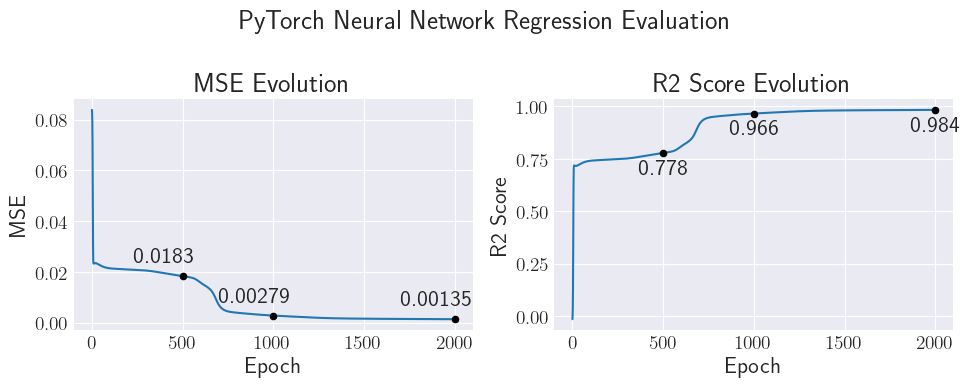

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_evolution)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE Evolution')

ax[1].plot(r2_evolution)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('R2 Score')
ax[1].set_title('R2 Score Evolution')

marked_epochs = [500, 1000, 1999]
for epoch in marked_epochs:
	ax[0].annotate(f'{loss_evolution[epoch]:.3g}', 
				   (epoch, loss_evolution[epoch]), 
				   textcoords="offset points", 
				   xytext=(-14, 10), 
				   ha='center')
	ax[1].annotate(f'{r2_evolution[epoch]:.3g}', 
				   (epoch, r2_evolution[epoch]), 
				   textcoords="offset points", 
				   xytext=(0, -15), 
				   ha='center')
	
ax[0].scatter(marked_epochs, [loss_evolution[epoch] for epoch in marked_epochs], color='black', s=20, zorder=10)
ax[1].scatter(marked_epochs, [r2_evolution[epoch] for epoch in marked_epochs], color='black', s=20, zorder=10)

fig.suptitle("PyTorch Neural Network Regression Evaluation")
plt.tight_layout()
plt.savefig("../figs/nn_torch_franke.pdf")
plt.show()


# Breast Cancer Classification problem with PyTorch

In [48]:
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
#Transform to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 10),
            nn.Sigmoid(),
            nn.Linear(10, 5),
            nn.Sigmoid(),
            nn.Linear(5, 2),
            )

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

#Define the Accuracy function
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    return correct / total

In [50]:
#Model definition
model = Network(X.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()
num_epochs = 2000
batch_size = 32

#Store metrics evolution
train_loss_evolution_pytorch = []
train_accuracy_evolution_pytorch = []
test_loss_evolution_pytorch = []
accuracy_evolution_pytorch = []

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_data = X_train[i:i+batch_size]
        batch_target = y_train[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)

        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    #Evaluate on train dataset
    model.eval()
    output = model(X_train)
    loss_value = loss(output, y_train)
    train_loss_evolution_pytorch.append(loss_value.item())
    train_accuracy_evolution_pytorch.append(accuracy(output, y_train))

    #Evaluate on test dataset
    output = model(X_test)
    loss_value = loss(output, y_test)
    test_loss_evolution_pytorch.append(loss_value.item())
    accuracy_evolution_pytorch.append(accuracy(output, y_test))

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss_evolution_pytorch[-1]} | Train Accuracy: {train_accuracy_evolution_pytorch[-1]} | Test Loss: {test_loss_evolution_pytorch[-1]} | Test Accuracy: {accuracy_evolution_pytorch[-1]}')

Epoch 0 | Train Loss: 0.7134639024734497 | Train Accuracy: 0.37142857142857144 | Test Loss: 0.7127635478973389 | Test Accuracy: 0.37719298245614036
Epoch 100 | Train Loss: 0.6526746153831482 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.6557755470275879 | Test Accuracy: 0.6228070175438597
Epoch 200 | Train Loss: 0.5897090435028076 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.5912449955940247 | Test Accuracy: 0.6228070175438597
Epoch 300 | Train Loss: 0.2562929689884186 | Train Accuracy: 0.9472527472527472 | Test Loss: 0.24185360968112946 | Test Accuracy: 0.956140350877193
Epoch 400 | Train Loss: 0.12549377977848053 | Train Accuracy: 0.9758241758241758 | Test Loss: 0.11097905039787292 | Test Accuracy: 0.9824561403508771
Epoch 500 | Train Loss: 0.09027818590402603 | Train Accuracy: 0.978021978021978 | Test Loss: 0.0814027190208435 | Test Accuracy: 0.9824561403508771
Epoch 600 | Train Loss: 0.0758330449461937 | Train Accuracy: 0.9824175824175824 | Test Loss: 0.070637099444866

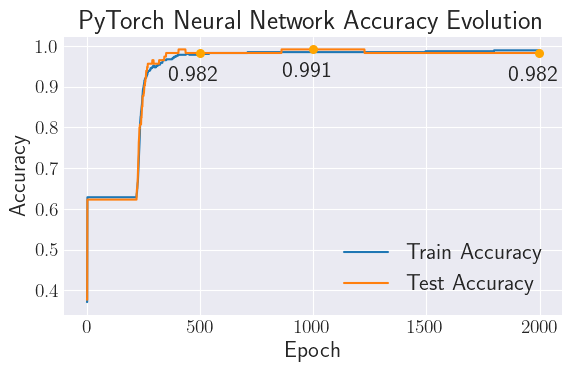

In [ ]:
fig  = plt.figure(figsize=(6,4))

plt.plot(train_accuracy_evolution_pytorch, label='Train Accuracy')
plt.plot(accuracy_evolution_pytorch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PyTorch Neural Network Accuracy Evolution')
plt.legend()

marked_epochs = [500, 1000, 1999]
for epoch in marked_epochs:
	plt.annotate(f'{accuracy_evolution_pytorch[epoch]:.3g}', 
				   (epoch, accuracy_evolution_pytorch[epoch]), 
				   textcoords="offset points", 
				   xytext=(-5, -20), 
				   ha='center')
	
plt.scatter(marked_epochs, [accuracy_evolution_pytorch[epoch] for epoch in marked_epochs], color='orange', s=30, zorder=10)

plt.tight_layout()
plt.savefig("../figs/nn_torch_breast_cancer.pdf")
plt.show()

# Logistic Regression with Skicit-learn

In [52]:
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000, solver='lbfgs')
logistic_regression.fit(X_train, y_train)

#Evaluate the model
train_accuracy_skicit = logistic_regression.score(X_train, y_train)
test_accuracy_scikit = logistic_regression.score(X_test, y_test)
print(f'Actual data\nTrain accuracy: {train_accuracy_skicit}')
print(f'Test accuracy: {test_accuracy_scikit} \n')

#Again with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logistic_regression.fit(X_train_scaled, y_train)
train_accuracy_skicit = logistic_regression.score(X_train_scaled, y_train)
test_accuracy_scikit = logistic_regression.score(X_test_scaled, y_test)
print(f'Scaled data\nTrain accuracy: {train_accuracy_skicit}')
print(f'Test accuracy: {test_accuracy_scikit}\n')

#Cross validation
scores = cross_validate(logistic_regression, X, y, cv=10)['test_score']
print(f'Cross validation scores: {scores}')

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Actual data
Train accuracy: 0.9604395604395605
Test accuracy: 0.956140350877193 

Scaled data
Train accuracy: 0.9868131868131869
Test accuracy: 0.9736842105263158



C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Cross validation scores: [0.94736842 0.9122807  0.92982456 0.94736842 0.96491228 0.98245614
 0.92982456 0.94736842 0.96491228 0.96428571]


C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


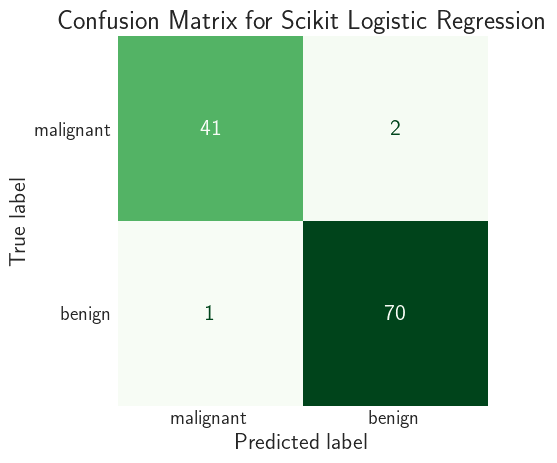

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot the confusion matrix
# Predict the labels for the test set
y_pred = logistic_regression.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_names)
disp.plot(cmap=plt.cm.Greens, colorbar=False)
plt.grid(False)
plt.title('Confusion Matrix for Scikit Logistic Regression')
plt.savefig("../figs/logistic_regression_confusion_matrix.pdf")
plt.show()